Importing the Libraries to perform the classification

In [26]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

Loading the Directory where the images are stored

In [27]:
PATH1 =os.getcwd()+'/Skin_Cancer/train_dir'

In [28]:
PATH2 = os.getcwd()+'/Skin_Cancer/val_dir'


In [29]:
os.listdir(PATH1)

['akiec', '.DS_Store', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel']

In [30]:
os.listdir(PATH2)

['akiec', '.DS_Store', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel']

Perfroming data preprocessing using the ResNet50 Prerpocess_input function.

In [54]:

datagen=ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Build for training
trainGeneratorBuild = datagen.flow_from_directory(
    PATH1,
    target_size = (224, 224), #setting the input shape
    class_mode = 'categorical',
    batch_size = 10,
    shuffle= True
)
# Build for test
testGeneratorBuild = datagen.flow_from_directory(
    PATH2,
    target_size=(224, 224),  # setting the input shape
    class_mode = 'categorical',
    batch_size = 10,
    shuffle=True
)


Found 38568 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


Exploratory Data Analysis

In [56]:
class_names = trainGeneratorBuild .class_indices
print(class_names)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [57]:
classes = list(class_names.keys())
print(classes)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [58]:
#identifying the preprocessed images and outputting them
images,labels = next(trainGeneratorBuild)
labels = np.argmax(labels, axis=1)
class_dict = trainGeneratorBuild.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in labels]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

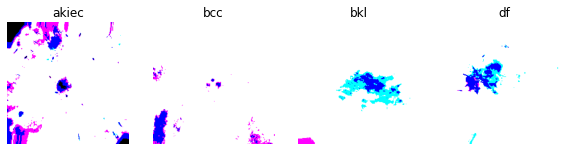

In [59]:
plt.figure(figsize=(10, 10))
for image in images:
    j  = 0
    for i in range(4):
        ax = plt.subplot(1, 4, i+1)
        for k in range(len(labels)):
            if labels[k] == j:
                plt.imshow(images[k])
                plt.title(classes[i])
                plt.axis("off")
                break
        j = j+1

Generating the Count of each image category in the dataset.

In [60]:
all_items,dirs,files = next(os.walk(PATH1))

In [61]:
image_in_classes = []
for i in range(len(dirs)):
    no_of_images =len(os.listdir(os.path.join(PATH,dirs[i])))
    image_in_classes.append(no_of_images)
df_data = {'class': dirs,'counts': image_in_classes}
classes_df = pd.DataFrame(df_data)    
    

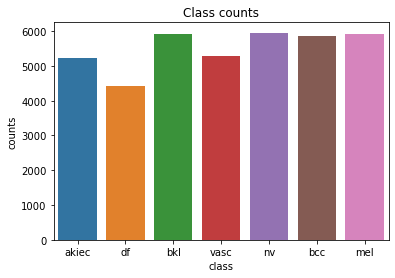

In [62]:
sns.barplot(x = 'class', y = 'counts',data = classes_df)
plt.title('Class counts')
plt.show()

Perfroming Transfer Learning by using the Resnet50 model.

In [63]:
from keras.applications.resnet import ResNet50 #loading the resnet50 model

In [64]:
res  = ResNet50( input_shape=(224,224,3), include_top=False) #using the final layer of resnet50 for our model to train.
#Thus we will not train the other layers of the model.

In [65]:
from tensorflow.keras import Model

Using Functional API model to create our model after transfer learning.

In [66]:
for layer in res.layers:  #make all the layers to train false we will use the pre-trained model.
  layer.trainable = False
x= res.output
x=GlobalAveragePooling2D()(x)  #maxpooling the output of the resnet50 model.
#adding our own fully connected layers to train the model.
x= Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
out =layers.Dense(7, activation='softmax')(x) #we have 7 as there are 7 types of skin cancer to classify.


# Creating our model
model = Model(inputs=res.input, outputs=out)

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [67]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #compiling our model.

In [68]:
 early_stop = EarlyStopping(monitor='val_loss',   #early stopping to prevent the model to train further if the learning rate does not improve.
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)

Setting our Checkpoint for finding the best fit from epoch and save it in h5 format

In [69]:
filepath = "/Users/aqdus/desktop/Skin/resnet_model.h5"  # destination to save our model
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#we are monitoring the val_loss for our best model.


In [70]:
# Add weights to try to make the model more sensitive to melanoma

class_weights = {
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 3.0,  # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0,  # nv
    6: 1.0,  # vasc
}


In [71]:
#fitting our model and running it with hyperparameter tuning.
history=model.fit(trainGeneratorBuild,batch_size=10, epochs=20, validation_data=testGeneratorBuild,callbacks = [early_stop,mc],verbose=1,class_weight=class_weights,steps_per_epoch=908,validation_steps=94)

Epoch 1/20


2022-04-23 23:45:24.020541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


908/908 [==============================] - ETA: 0s - loss: 1.4187 - accuracy: 0.5316

2022-04-23 23:47:03.318706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


908/908 [==============================] - 110s 121ms/step - loss: 1.4187 - accuracy: 0.5316 - val_loss: 0.4866 - val_accuracy: 0.8092

Epoch 00001: val_loss improved from inf to 0.48660, saving model to /Users/aqdus/desktop/Skin/resnet_model.h5


/Users/aqdus/miniforge3/envs/mlp/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
908/908 [==============================] - 109s 121ms/step - loss: 1.0960 - accuracy: 0.6461 - val_loss: 0.6574 - val_accuracy: 0.7527

Epoch 00002: val_loss did not improve from 0.48660
Epoch 3/20
908/908 [==============================] - 109s 120ms/step - loss: 0.9979 - accuracy: 0.6819 - val_loss: 0.5665 - val_accuracy: 0.7985

Epoch 00003: val_loss did not improve from 0.48660
Epoch 4/20
908/908 [==============================] - 112s 123ms/step - loss: 0.9252 - accuracy: 0.7075 - val_loss: 0.4378 - val_accuracy: 0.8443

Epoch 00004: val_loss improved from 0.48660 to 0.43783, saving model to /Users/aqdus/desktop/Skin/resnet_model.h5
Epoch 5/20
908/908 [==============================] - 115s 126ms/step - loss: 0.8605 - accuracy: 0.7265 - val_loss: 0.4849 - val_accuracy: 0.8316

Epoch 00005: val_loss did not improve from 0.43783
Epoch 6/20
908/908 [==============================] - 113s 125ms/step - loss: 0.8083 - accuracy: 0.7419 - val_loss: 0.4837 - val_accuracy: 0.8358

Calculating the overall Train and Test/Validation score

In [72]:
print("Train score:", model.evaluate(trainGeneratorBuild))
print("Test score:", model.evaluate(testGeneratorBuild))
n_epochs = len(history.history['loss'])

3857/3857 [==============================] - 472s 122ms/step - loss: 0.5728 - accuracy: 0.7760
Train score: [0.5727850794792175, 0.7759801149368286]
94/94 [==============================] - 13s 134ms/step - loss: 0.4000 - accuracy: 0.8667
Test score: [0.40002918243408203, 0.8667377829551697]


We see that we have a validation accuracy of 86.6 Percent and validation loss of 4 Percent.

Plotting
1. Training and Validation accuracy
2. Training and Validation loss

In [73]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

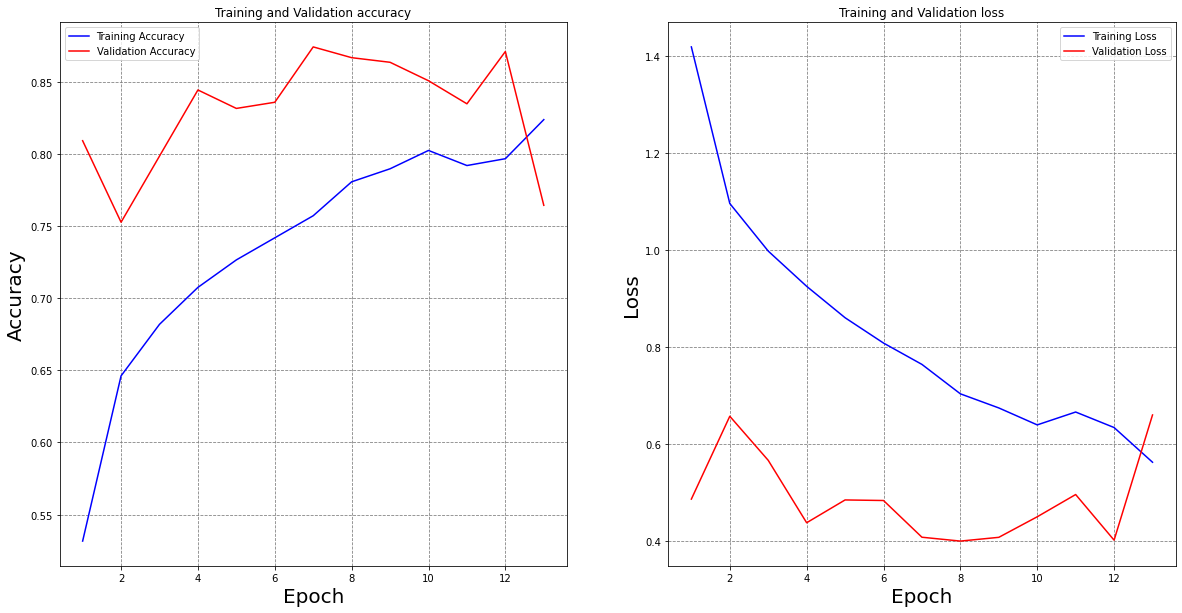

In [74]:
plotLearningCurve(history,n_epochs)

Taking a sample and visulizing the effieciency of the model created from transfer learning (Resnet50) on a test image sample.

In [75]:
from tensorflow.keras.preprocessing import image

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)
  img = np.expand_dims(img , axis= 0 )
  
  return img

The given Skin_Cancer image is of type = nv

The chances of image being akiec is : 0.37217496428638697 percent

The chances of image being bcc is : 1.3342509046196938 percent

The chances of image being bkl  is : 11.827773600816727 percent

The chances of image being df is : 0.05971365608274937 percent

The chances of image being mel is : 1.968577317893505 percent

The chances of image being nv  is : 84.22113060951233 percent

The chances of image being vasc is : 0.2163775498047471 percent



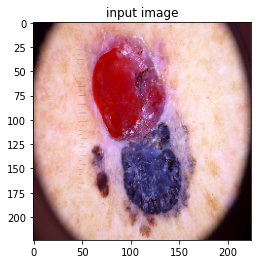

In [78]:
# path for that new image.
PATH = os.getcwd()+'/ISIC_0025234.jpg'
# you can add any image path
img = get_img_array(PATH)
'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'
res = classes[np.argmax(model.predict(img))]
print(f"The given Skin_Cancer image is of type = {res}")
print()
print(f"The chances of image being akiec is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being bcc is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being bkl  is : {model.predict(img)[0][2]*100} percent")
print()
print(f"The chances of image being df is : {model.predict(img)[0][3]*100} percent")
print()
print(
    f"The chances of image being mel is : {model.predict(img)[0][4]*100} percent")
print()
print(
    f"The chances of image being nv  is : {model.predict(img)[0][5]*100} percent")
print()
print(
    f"The chances of image being vasc is : {model.predict(img)[0][6]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()


We notice that the classification has been correctly performed and the image has been identified as nv type of skin cancer.